In [202]:
# torch import
import torch
import torch.nn as nn  # layer의 수, 각 layer의 뉴런 수 등 네트워크 구축 시 필요한 기본 특징 일부를 대신 정의해줌
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

# utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [204]:
# GPU 연결 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Preprocessing

In [207]:
# Data Load-CIFAR10
train_data = datasets.CIFAR10(root="./data/", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./data/", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


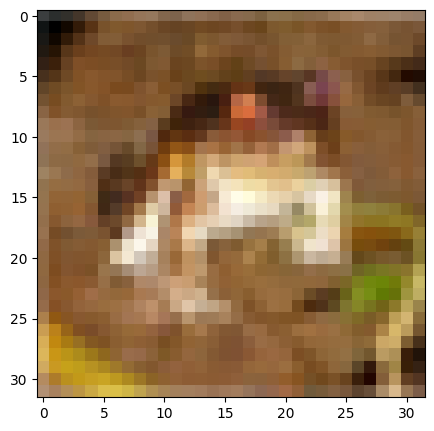

In [208]:
# visualization
dataiter = iter(train_data)
image,label = next(dataiter)
img = make_grid(image, padding=0)
npimg = img.numpy()

plt.figure(figsize=(5,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [209]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_data]  # 데이터에서 이미지만 추출하여 이미지의 RGB 픽셀 평균을 구함
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_data]    # 데이터에서 이미지만 추출하여 이미지의 RGB 픽셜 표준편차를 구함

# train_memeRGB   # array([0.5537454 , 0.41215533, 0.25112593], dtype=float32) -> index 0=R, index 1=G, index 2=B

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(train_stdR, train_stdG, train_stdB)

0.49139965 0.48215845 0.4465309
0.20220213 0.19931543 0.20086348


In [222]:
# data preprocessing
data_transformer = transforms.Compose([transforms.Resize((256)),  # 입력 이미지 크기를 256로 다운 샘플링함
                                      transforms.ToTensor(),
                                      transforms.RandomResizedCrop(227),  # 256x256 input image를 227x227 크기의 patch로 무작위 자름(data augmentation) 
                                      transforms.RandomHorizontalFlip(),  # 좌우반전을 통해 data augmentation
                                      transforms.Normalize(mean=(train_meanR, train_meanG, train_meanB), std=(train_stdR, train_stdG, train_stdB))
                                      ])  # RGB별 정규화된 값 계산 = (입력값 - 평균(mean))/표준편차(std)


train_data.transform = data_transformer
test_data.transform = data_transformer

# AlexNet batch size 참고
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers=2)

## Create Model

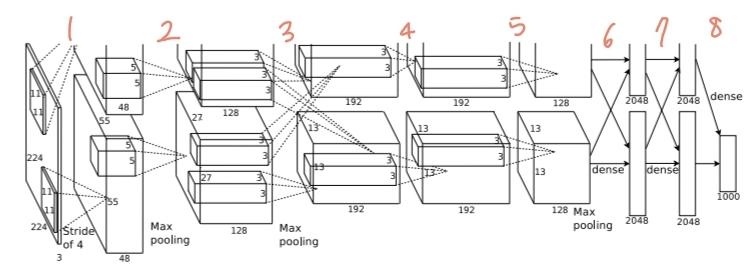

In [225]:
# create AlexNet model
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            # Conv1 laeyr
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv2 laeyr
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3 laeyr
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv4 laeyr
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv5 laeyr
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc = nn.Sequential(
            # Fc1 layer
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(inplace=True),

            # Fc2 layer
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),

            # Fc3 layer
            nn.Linear(in_features=4096, out_features=10),  # 입력 데이터셋에 맞게 10개의 클래스로 출력하도록 함
            nn.LogSoftmax(dim=1)
        )

        self.init_weight_bias()

    def init_weight_bias(self):
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)  # 각 layer에 zero-mean Gaussian distribution을 적용함
                nn.init.constant_(layer.bias, 0)
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 256*6*6)
        x = self.fc(x)
        return x

In [227]:
import torchsummary

model = AlexNet()
model.to(device)

torchsummary.summary(model, input_size=(3, 227, 227), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

## Model Train

In [230]:
import torch.optim as optim

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# optimizer.zero_grad()
loss_fn = nn.CrossEntropyLoss()

In [264]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    model.train()

    # loss와 accuracy 계산을 위한 변수
    total_train = 0
    total_loss_train = 0
    correct_train = 0

    progress_bar = tqdm(data_loader)

    for batch_idx, (img,label) in enumerate(progress_bar, start=1):
        img, label = img.to(device), label.to(device)  # image, label 데이터를 device에 올림
        optimizer.zero_grad()  # 이전 layer에서 계산했던 gradient를 0올 초기화함
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()   # 오차에 대한 back propagation 진행하여 미분 값 계산함
        optimizer.step()  # 계산한 gradient를 업데이트함

        # output의 max(dim=1) : max probability와 max index 반환함
        _, pred = output.max(dim=1)   # max index를 pred에 저장 후 label값과 대조하여 정확도 도출함
        correct_train += pred.eq(label).sum().item()  # 정확히 맞춘 label의 합계 계산 후 correct_train에 누적함
        total_train += img.size(0)
        total_loss_train += loss.item()
        
        progress_bar.set_description(f'[Training] loss: {total_loss_train / total_train:.4f}, accuracy: {100*(correct_train / total_train)}')

    acc = correct_train / total_train

    # train_loss, train_acc <- 평균 손실(loss)과 정확도 반환
    return total_loss_train / total_train, acc

In [266]:
def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()

    # gradient가 업데이트되는 것을 방지
    with torch.no_grad():
        correct_test = 0
        total_loss_test = 0

        for img, label in data_loader:
            img, label = img.to(device), label.to(device)
            output = model(img)
            _, pred = output.max(dim=1)
            
            correct_test += torch.sum(pred.eq(label)).item()
            total_loss_test += loss_fn(output, label).item()

        acc = correct_test / len(data_loader.dataset)

        # val_loss, val_acc
        return total_loss_test / len(data_loader.dataset), acc

In [268]:
min_loss = np.inf
num_epochs = 1

for epoch in range(num_epochs):
    train_loss, train_acc = model_train(model, trainloader, loss_fn, optimizer, device)
    val_loss, val_acc = model_evaluate(model, testloader, loss_fn, device)

    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}.')
        min_loss = val_loss

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')


[Training] loss: 0.0180, accuracy: 10.546875:   1%|          | 2/391 [00:03<10:17,  1.59s/it]
[Training] loss: 0.0180, accuracy: 11.458333333333332:   1%|          | 2/391 [00:03<10:17,  1.59s/it]
[Training] loss: 0.0180, accuracy: 11.458333333333332:   1%|          | 3/391 [00:03<06:04,  1.06it/s]
[Training] loss: 0.0180, accuracy: 11.875:   1%|▏         | 5/391 [00:04<03:05,  2.08it/s]
[Training] loss: 0.0180, accuracy: 11.197916666666668:   1%|▏         | 5/391 [00:04<03:05,  2.08it/s]
[Training] loss: 0.0180, accuracy: 11.197916666666668:   2%|▏         | 6/391 [00:04<02:24,  2.67it/s]
[Training] loss: 0.0180, accuracy: 10.714285714285714:   2%|▏         | 6/391 [00:04<02:24,  2.67it/s]
[Training] loss: 0.0180, accuracy: 10.714285714285714:   2%|▏         | 7/391 [00:04<02:19,  2.76it/s]
[Training] loss: 0.0180, accuracy: 10.44921875:   2%|▏         | 8/391 [00:05<01:55,  3.31it/s]
[Training] loss: 0.0180, accuracy: 9.722222222222223:   2%|▏         | 8/391 [00:05<01:55,  3.31it/s

[INFO] val_loss has been improved from inf to 0.01819.
epoch 01, loss: 0.01801, acc: 0.09822, val_loss: 0.01819, val_accuracy: 0.10000
